# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [ ]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [ ]:

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 8s 0us/step


**2) Check the shape of images and targets.**

In [ ]:
print(np.shape(X_train))  # the shape of the input of the training set
print(np.shape(X_train[0])) # the shape of each input data
print(np.shape(y_train))  # the shape of the target value of the training set
print(np.shape(y_train[0])) # the shape of the target value of each sample
print(np.shape(X_test))  # the shape of the input of the test set
print(np.shape(X_test[0])) # the shape of each input data
print(np.shape(y_test))  # the shape of the target value of the test set
print(np.shape(y_test[0])) # the shape of the target value of each sample



(50000, 32, 32, 3)
(32, 32, 3)
(50000, 1)
(1,)
(10000, 32, 32, 3)
(32, 32, 3)
(10000, 1)
(1,)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # create a list of labels


**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [ ]:
# the maximum value is 255, so all the data can be converted to be [0,1] by being divided by 255
x_train_normalized = X_train / 255  
x_test_normalized = X_test / 255 


**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [ ]:
# convert the target to one-hot encoding. Since there're 10 classes, then the vector's length is 10.
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

In [ ]:
# create a dictionary with label as the key and a list of the first 8 images data as the value

images = dict() 
for i in range(10):
  images[i] = []
flags = [True]*10 # mark if each class has already got 8 images

for i in range(len(X_train)):
  label = y_train[i][0]  # use y_train the original target value to find the label index
  if any(flags):
    if flags[label]:
      images[label].append(X_train[i])
      flags[label] = len(images[label]) < 8 # check to update the mark everytime after adding image data
    else:
      continue
  else:
    break


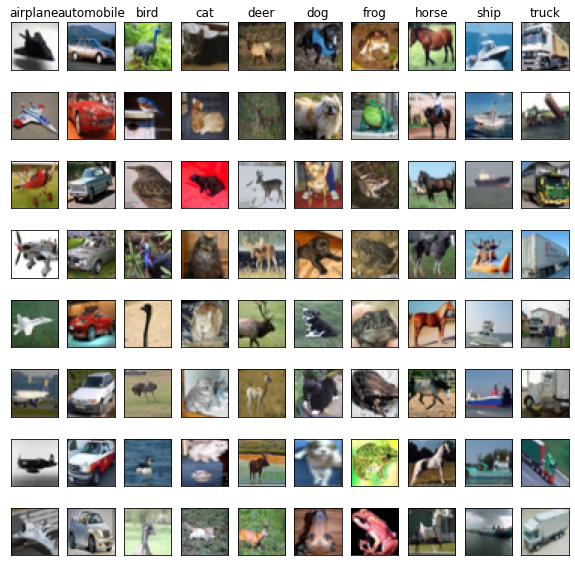

In [ ]:
#The following code summarizes all previous operations. 
#No Need to fill in this cell. You can continue the lab.

# define row and column of figure
rows, columns = 8, 10

f, axarr = plt.subplots(rows, columns)
f.set_size_inches(10, 10)

# visualize the images from the dictionary
for i in range(rows):
  for j in range(columns):
    img = images[j][i] # each column contains one class, so column number j is the key in the dictionary and i indicates the ith image in this class
    fig = axarr[i,j].imshow(img)
    if i == 0:
      axarr[i, j].set_title(labels[j]) # only the first row shows the labels
    fig.axes.get_xaxis().set_visible(False) 
    fig.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# before training, split the training data into train set and validation set in order to have the same training and validation data for different models

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train_normalized, y_train_cat, test_size=0.2, shuffle= True)

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task. For the training, use the SGD optimizer with a learning rate of 0.1 and a decay of $10^{-6}$. The performance of the network will be assessed via the accuracy metric.**

In [ ]:
# change the data input size for dense model
x_train_dense = np.reshape(x_train,(-1,3072))
x_valid_dense = np.reshape(x_valid,(-1,3072))
x_test_dense = np.reshape(x_test_normalized,(-1,3072))
def init_model_dense():
  model = Sequential()
  model.add(Input(shape=(3072,)))
  model.add(Dense(1024, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  sgd = SGD(learning_rate=0.1, decay=1e-6)

  model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model


**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

Dense layer is full connection layer, so the number of parameters for each layer will be the input size multiplies output sizes, plus bias

In [ ]:
num_params = (3072*1024+1024) + (1024*512+512) + (512*256+256) + (256*100+100)  + (10*100+10)
print(num_params)

3829590


**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [ ]:
model_dense = init_model_dense()

model_dense.summary()

# The result matches with the num_params computed by hand

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 100)               25700     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 3,829,590
Trainable params: 3,829,590
Non-trainable params: 0
_________________________________________________________________


**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

history = model_dense.fit(x_train_dense, y_train, validation_data=(x_valid_dense, y_valid), epochs=10, batch_size=32, 
                    callbacks=[callback], verbose=2)


Epoch 1/10
1250/1250 - 8s - loss: 1.9483 - accuracy: 0.2928 - val_loss: 1.7755 - val_accuracy: 0.3625 - 8s/epoch - 6ms/step
Epoch 2/10
1250/1250 - 4s - loss: 1.7504 - accuracy: 0.3692 - val_loss: 1.6633 - val_accuracy: 0.4087 - 4s/epoch - 3ms/step
Epoch 3/10
1250/1250 - 4s - loss: 1.6591 - accuracy: 0.4053 - val_loss: 1.6763 - val_accuracy: 0.4078 - 4s/epoch - 3ms/step
Epoch 4/10
1250/1250 - 4s - loss: 1.5969 - accuracy: 0.4282 - val_loss: 1.5329 - val_accuracy: 0.4535 - 4s/epoch - 3ms/step
Epoch 5/10
1250/1250 - 4s - loss: 1.5442 - accuracy: 0.4448 - val_loss: 1.5495 - val_accuracy: 0.4473 - 4s/epoch - 3ms/step
Epoch 6/10
1250/1250 - 4s - loss: 1.4997 - accuracy: 0.4630 - val_loss: 1.4840 - val_accuracy: 0.4675 - 4s/epoch - 3ms/step
Epoch 7/10
1250/1250 - 4s - loss: 1.4645 - accuracy: 0.4722 - val_loss: 1.5523 - val_accuracy: 0.4459 - 4s/epoch - 3ms/step
Epoch 8/10
1250/1250 - 5s - loss: 1.4225 - accuracy: 0.4885 - val_loss: 1.4624 - val_accuracy: 0.4817 - 5s/epoch - 4ms/step
Epoch 9/

We see that the accuracy on the validation data hovers around 0.47. It is better than random guess which has 10% chance to get the right result.

**11) Plot several images with their predictions. Any comment?**

1250/1250 [==============================] - 2s 2ms/step


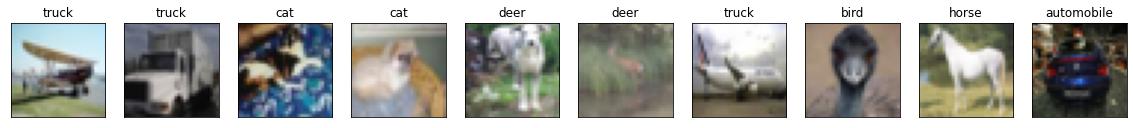

In [ ]:
predict_x = model_dense.predict(x_train_dense) 
final_x = (predict_x == predict_x.max(axis=1, keepdims=1)).astype(float)
f, axarr = plt.subplots(1, 10)
f.set_size_inches(20, 10)

for i in range(10):
    img = x_train[i]
    fig = axarr[i].imshow(img)
    axarr[i].set_title(labels[np.argmax(final_x[i])])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
plt.show()


It seems can not recognized well about track and airplane, also about deer.

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [ ]:
def init_model_cnn():
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Flatten())
  model.add(Dense(408, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

It is much less than the dense net work because it convolutional layers is not full connection layers, which reduces the amount of parameters, hence computation drastically.

In [ ]:
c1_paras = (3*3*3+1)*8 # ouput shape is (32,32,8)
c2_paras = (8*3*3+1)*8 # ouput shape is (30,30,8)
# max pooling layer 1 ouput shape is (15,15,8)
c3_paras = (8*3*3+1)*32 # ouput shape is (15,15,32)
c4_paras = (32*3*3+1)*32 # ouput shape is (13,13,32)
# max pooling layer 2 ouput shape is (6,6,32)
d1_paras = 6*6*32*408 + 408
ouput_paras = 408*10 + 10
total_paras = c1_paras + c2_paras + c3_paras + c4_paras +d1_paras + ouput_paras
print(f'Total parameters comnputed is {total_paras}')

Total parameters comnputed is 486906


In [ ]:
model_cnn = init_model_cnn()
#print(model)

y = model_cnn(x_train)
model_cnn.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1250/1250 [==============================] - 9s 6ms/step - loss: 1.6587 - accuracy: 0.3968 - val_loss: 1.3486 - val_accuracy: 0.5136
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                     

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [ ]:
model_cnn = init_model_cnn()

model_cnn.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=10)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
1250/1250 [==============================] - 15s 5ms/step - loss: 1.6231 - accuracy: 0.4127 - val_loss: 1.4456 - val_accuracy: 0.4795
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.2121 - accuracy: 0.5684 - val_loss: 1.0931 - val_accuracy: 0.6219
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0121 - accuracy: 0.6435 - val_loss: 1.0106 - val_accuracy: 0.6524
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8656 - accuracy: 0.6955 - val_loss: 0.9805 - val_accuracy: 0.6660
Epoch 5/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7440 - accuracy: 0.7390 - val_loss: 0.9486 - val_accuracy: 0.6781
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6292 - accuracy: 0.7792 - val_loss: 1.0723 - val_accuracy: 0.6601
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5178 - accuracy: 0.8183 - val_loss: 1.1668 - val_accuracy

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs


def plot_accuracy_losses(mod, title):
  f, ax = plt.subplots(1, 2)
  f.set_size_inches(10,5)
  ax[0].plot(mod.history.history['accuracy'], label='Accuracy')
  ax[0].plot(mod.history.history['val_accuracy'], label='Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_ylim([0,1])
  ax[0].title.set_text('Accuracy with ' + title)
  ax[0].legend()

  ax[1].plot(mod.history.history['loss'], label='Loss')
  ax[1].plot(mod.history.history['val_loss'], label='Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].title.set_text('Loss with ' + title)
  ax[1].legend()

  f.show()

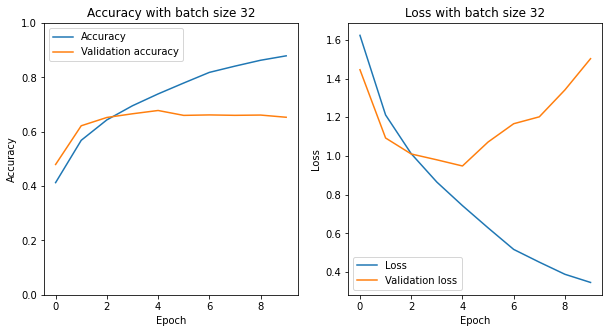

In [ ]:
plot_accuracy_losses(model_cnn, 'batch size 32')

The validation accuracy is stable after around 3 epoches, then there is overfitting. The accuracy is around 0.65, better than the dense layer model.

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

Small batch size of 16 updates parameters frequently, which lead to the turbulence on validation data set as we can see below. Also it underfits comparing to batch size of 32 and 64. Larger batch size trained model is more stable when generalize it on validation data set, it converges fast. The problem is the large training time and memory requirement.

In [ ]:
batch_sizes = [16, 32, 64]
train_performance = []
val_performance = []

for b in batch_sizes:
  model_cnn = init_model_cnn()
  print("training with batch size " + str(b))
  model_cnn.fit(x_train, y_train, batch_size=b, validation_data=(x_valid, y_valid), epochs=10)
  val_performance.append(model_cnn.history.history['val_accuracy'])
  train_performance.append(model_cnn.history.history['accuracy'])
  del model_cnn


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


training with batch size 16
Epoch 1/10
2500/2500 [==============================] - 16s 5ms/step - loss: 1.6704 - accuracy: 0.3882 - val_loss: 1.4454 - val_accuracy: 0.4949
Epoch 2/10
2500/2500 [==============================] - 19s 7ms/step - loss: 1.2632 - accuracy: 0.5500 - val_loss: 1.2151 - val_accuracy: 0.5685
Epoch 3/10
2500/2500 [==============================] - 13s 5ms/step - loss: 1.0970 - accuracy: 0.6120 - val_loss: 1.1723 - val_accuracy: 0.5977
Epoch 4/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.9903 - accuracy: 0.6555 - val_loss: 1.1567 - val_accuracy: 0.5958
Epoch 5/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.9071 - accuracy: 0.6865 - val_loss: 1.1305 - val_accuracy: 0.6285
Epoch 6/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.8561 - accuracy: 0.7029 - val_loss: 1.3680 - val_accuracy: 0.5777
Epoch 7/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.8130 - accuracy: 0.7204

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

def plot_accuracy_batch(train_per, val_per, param):
  for i in range(len(param)):
    lt = 'training (batch_size = %d)'%(param[i])
    lv = 'validation (batch_size = %d)'%(param[i])
    plt.plot(train_per[i], '--', label=lt)
    plt.plot(val_per[i], '-', label=lv)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0,1])
  plt.title('Accuracy in training and validation set for different batch sizes')
  plt.legend(bbox_to_anchor=(1.1,1.1))
  plt.show()


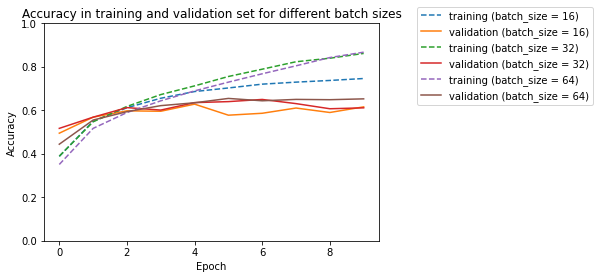

In [ ]:
plot_accuracy_batch(train_performance, val_performance, batch_sizes)

**16) Consider now a batch size of 32 and consider the above CNN. Try adding 3 dropout layers to this model, one after each max-pooling layer and one before the last layer, using a dropout of parameter p=0.25. Does this improve the model? How does the performance vary with the dropout ratio? What does p correspond to?**

With the dropout of p=0.25, the overfitting happens around epoch 8 now with batch size 32, comparing to before it happense during epoch 4. However, there is no much improvement on the generalization accuracy after 10 epoch. Hence I would not see it improve the model. 

We try p = 0.1, 0.25, 0.5 to see how the drop out ratio will impact the model performance. P is the ration that at each iteration, some neurons (p is the percentage) are randomly dropped out (input will be set to zero) and will not participate in forward and backward propagation.

we could tell from below the plot result that if the drop out p is too large, it leads to underfiting eventually. The accuracy on validation set is around 0.4, which is worse than without dropout layer.

In [ ]:

def init_model_dropout(p):
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(p))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(p))
  model.add(Flatten())
  model.add(Dense(408, activation='relu'))
  model.add(Dropout(p))
  model.add(Dense(10, activation='softmax'))

  optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
dropouts = [0.1, 0.25, 0.5]

train_performance = []
val_performance = []

for p in dropouts:
  model_cnn = init_model_dropout(p)
  print("training with dropout = %d "%(p))
  model_cnn.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=10)
  val_performance.append(model_cnn.history.history['val_accuracy'])
  train_performance.append(model_cnn.history.history['accuracy'])
  del model_cnn

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


training with dropout = 0 
Epoch 1/10
1250/1250 [==============================] - 16s 10ms/step - loss: 1.7494 - accuracy: 0.3655 - val_loss: 1.4702 - val_accuracy: 0.4760
Epoch 2/10
1250/1250 [==============================] - 13s 10ms/step - loss: 1.3681 - accuracy: 0.5055 - val_loss: 1.2825 - val_accuracy: 0.5381
Epoch 3/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1906 - accuracy: 0.5761 - val_loss: 1.1166 - val_accuracy: 0.6053
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0683 - accuracy: 0.6204 - val_loss: 1.0274 - val_accuracy: 0.6369
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9635 - accuracy: 0.6612 - val_loss: 0.9947 - val_accuracy: 0.6484
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8879 - accuracy: 0.6883 - val_loss: 0.9455 - val_accuracy: 0.6722
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8168 - accuracy: 0.7111 - v

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

# Plot the evolution of (train/val) accuracy through epochs
def plot_accuracy_dropout(train_per, val_per, param):
  for i in range(len(param)):
    lt = 'training (dropout = %.2f)'%(param[i])
    lv = 'validation (dropout = %.2f)'%(param[i])
    plt.plot(train_per[i], '--', label=lt)
    plt.plot(val_per[i], '-', label=lv)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0,1])
  plt.title('Accuracy in training and validation set for different dropouts')
  plt.legend(bbox_to_anchor=(1.1,1.1))
  plt.show()

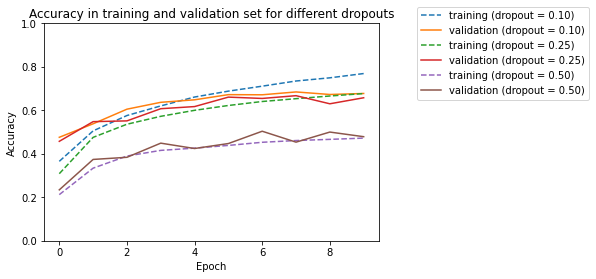

In [ ]:
plot_accuracy_dropout(train_performance, val_performance, dropouts)

**17) Add batch normalization layers before each dropout layer, with the dropout parameter of your choice. What is the impact of batch normalization on the model's performance?**

We choose dropout p = 0.1. Overall, there is some change in convergence speed but not much improvement on the final model after 10 epoch. Comparing to the result we see in question 14 where the best performance is accuracy around 0.67, here with batch normalization layers and dropout layers(0.1), the best result is around 0.69. Very small improvement.

In [ ]:
def init_model_normalized():
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(408, activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax'))

  optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs


model = init_model_normalized()
model.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=10)



Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.7494 - accuracy: 0.3896 - val_loss: 1.5206 - val_accuracy: 0.4802
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4072 - accuracy: 0.5000 - val_loss: 1.3946 - val_accuracy: 0.5090
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2518 - accuracy: 0.5595 - val_loss: 1.1955 - val_accuracy: 0.5837
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1234 - accuracy: 0.6043 - val_loss: 1.0866 - val_accuracy: 0.6248
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0370 - accuracy: 0.6323 - val_loss: 1.0136 - val_accuracy: 0.6426
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9658 - accuracy: 0.6610 - val_loss: 1.1372 - val_accuracy: 0.6127
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9070 - accuracy: 0.6812 - val_loss: 1.0125 - val_accuracy:

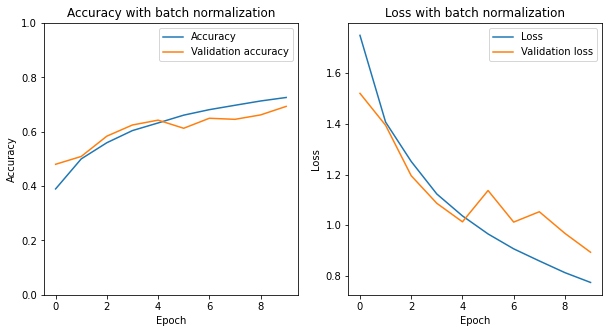

In [ ]:
plot_accuracy_losses(model, 'batch normalization')

**18) Based on the CNNs you have considered so far in this lab, what would be the next improvement you would like to test to increase the validation accuracy of your model? Test it and comment.**

Comment 1: The validation accuracy increased to over 0.7 after 15 epoches.

Comment 2: By furthur change the optimizer to rmsprop, the validation accuracy increased to over 0.72.

We could furthur try other optimizers or increase the layers/kernel size of our cnn to improve the model, however, it requires more computation resources which is limited for us.

In [ ]:
# First attempt: increase epoch

model = init_model_normalized()
model.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=30)



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
1250/1250 [==============================] - 17s 6ms/step - loss: 1.7260 - accuracy: 0.4011 - val_loss: 1.4973 - val_accuracy: 0.4791
Epoch 2/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3837 - accuracy: 0.5152 - val_loss: 1.3902 - val_accuracy: 0.5155
Epoch 3/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2079 - accuracy: 0.5803 - val_loss: 1.0940 - val_accuracy: 0.6137
Epoch 4/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0963 - accuracy: 0.6192 - val_loss: 1.2203 - val_accuracy: 0.5956
Epoch 5/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0164 - accuracy: 0.6446 - val_loss: 1.0528 - val_accuracy: 0.6357
Epoch 6/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9306 - accuracy: 0.6744 - val_loss: 1.0952 - val_accuracy: 0.6395
Epoch 7/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8733 - accuracy: 0.6926 - val_loss: 0.9360 - val_accuracy

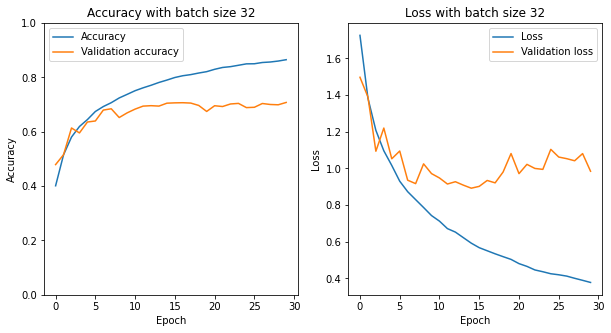

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs
plot_accuracy_losses(model, 'batch size 32')

In [ ]:
# Second attempt: change optimizer
from tensorflow.keras.optimizers import RMSprop
rms = RMSprop(lr=0.01)
def init_model_optim(optimizer):
  model = Sequential()

  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(408, activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model = init_model_optim(rms)
model.fit(x_train, y_train, batch_size=32, validation_data=(x_valid, y_valid), epochs=30)



Epoch 1/30
1250/1250 [==============================] - 10s 7ms/step - loss: 1.7539 - accuracy: 0.3919 - val_loss: 1.5637 - val_accuracy: 0.4726
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3163 - accuracy: 0.5309 - val_loss: 1.3505 - val_accuracy: 0.5289
Epoch 3/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.1747 - accuracy: 0.5880 - val_loss: 1.0617 - val_accuracy: 0.6276
Epoch 4/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0788 - accuracy: 0.6229 - val_loss: 1.0155 - val_accuracy: 0.6473
Epoch 5/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0211 - accuracy: 0.6441 - val_loss: 1.1033 - val_accuracy: 0.6354
Epoch 6/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.9375 - accuracy: 0.6793 - val_loss: 1.0816 - val_accuracy: 0.6671
Epoch 8/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.9059 - accuracy: 0.6916 - val_loss: 0.9891 - val_accuracy

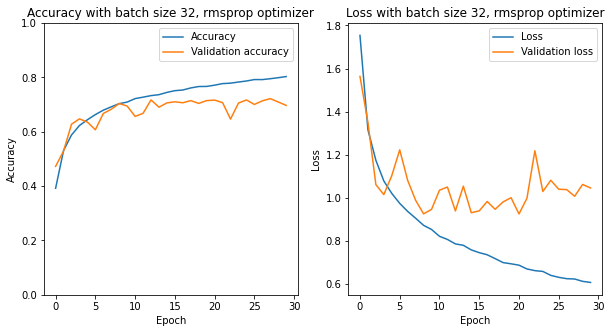

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs
plot_accuracy_losses(model, 'batch size 32, rmsprop optimizer')

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**19) Use `predict` on your trained model (the best you have created so far) to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for few test images. Compute the accuracy of your model on the test set and comment.**

NB: You can save the model after training it (function `save` in keras), and then decide to load from saved file instead of building a new one (if available) on successive runs (via the function `load_model` in keras).**

Comment: The result on test dataset has about 70% prediction correct, which is similar to the result we see on the validation dataset previously. Hence we could say our model has a good ability to generalize.

Detail: Out of ten pictures from test dataset, we can say 4 and 7 is predicted completely wrongly, where 8 is wrong but not that far away since it gives similar weight to the right answer. 

313/313 [==============================] - 1s 3ms/step


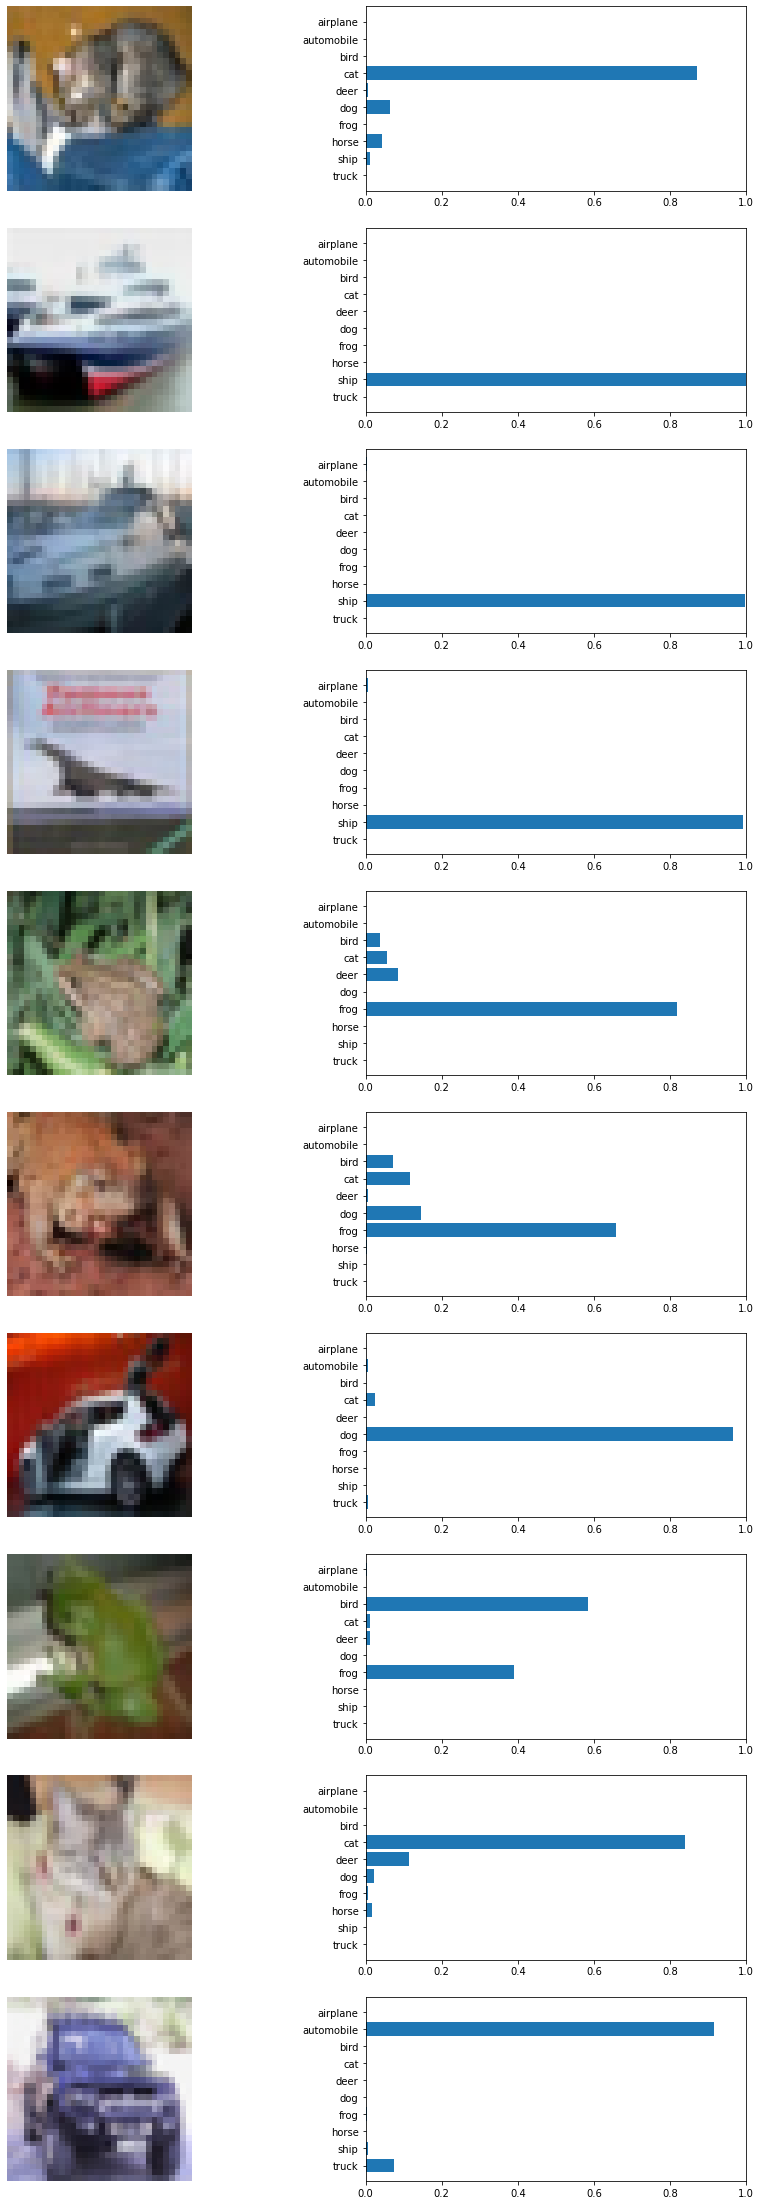

In [ ]:
prediction = model.predict(x_test_normalized)

f, axarr = plt.subplots(10, 2)
f.set_size_inches(15,40)
for i in range(10):
    axarr[i][0].imshow(x_test_normalized[i])
    axarr[i][0].axis('off')
    y_pos = np.arange(len(labels))
    performance = prediction[i]
    axarr[i][1].barh(y_pos, performance, align='center')
    axarr[i][1].set_xlim([0,1])
    axarr[i][1].set_yticks(y_pos)
    axarr[i][1].invert_yaxis()
    axarr[i][1].set_yticklabels(labels)
    
plt.show()


In [ ]:
# Compute the accuracy
predicted_labels = np.argmax(prediction, axis=1)
print("The accuracy on the test set is", metrics.accuracy_score(y_test, predicted_labels) )

print("The coverage error is", metrics.coverage_error(y_test_cat, prediction))

The accuracy on the test set is 0.6957
The coverage error is 1.6448


A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**20) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

Comment: 

1. It has some difficulties to recognize the difference between airplane and ship.

2. It arecognized a lot dogs as cat by mistake.

3. It has poor perfromance when the picture is deer. It consider deer as other animals.

4. The mistaked classficiation mainly happens inside animal or mechanicals, not between them. 

In [ ]:
cols = ['Predicted ' + l for l in labels]
rows = ['True ' + l for l in labels]
matrix = metrics.confusion_matrix(y_test, predicted_labels)

pandas.DataFrame(matrix, columns=cols, index=rows)


,Predicted airplane,Predicted automobile,Predicted bird,Predicted cat,Predicted deer,Predicted dog,Predicted frog,Predicted horse,Predicted ship,Predicted truck
True airplane,652,5,100,33,19,1,21,27,124,18
True automobile,7,790,18,22,7,3,14,13,81,45
True bird,39,1,679,76,51,22,75,41,15,1
True cat,9,5,89,615,23,84,84,62,25,4
True deer,10,0,130,111,494,24,113,100,17,1
True dog,4,1,94,263,25,460,47,91,13,2
True frog,2,2,34,61,12,12,860,11,5,1
True horse,6,0,41,61,23,16,16,832,4,1
True ship,23,8,21,26,7,4,10,11,880,10
True truck,29,69,18,48,5,7,17,53,59,695


<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**21) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np


In [ ]:
# Instantiate the model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, classes=10, input_shape=(32, 32, 3))
# add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully connected layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# add the output layer with number of classes
predictions = Dense(10, activation='softmax')(x)

# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# train the model
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=32, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 36s 29ms/step - loss: 1.1350 - accuracy: 0.6029 - val_loss: 0.8098 - val_accuracy: 0.7220
Epoch 2/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.7452 - accuracy: 0.7416 - val_loss: 0.7026 - val_accuracy: 0.7576
Epoch 3/10
1250/1250 [==============================] - 36s 28ms/step - loss: 0.6409 - accuracy: 0.7776 - val_loss: 0.6507 - val_accuracy: 0.7733
Epoch 4/10
1250/1250 [==============================] - 36s 28ms/step - loss: 0.5659 - accuracy: 0.8030 - val_loss: 0.6347 - val_accuracy: 0.7792
Epoch 5/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.5106 - accuracy: 0.8211 - val_loss: 0.5847 - val_accuracy: 0.7966
Epoch 6/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.4650 - accuracy: 0.8370 - val_loss: 0.5638 - val_accuracy: 0.8028
Epoch 7/10
1250/1250 [==============================] - 36s 28ms/step - loss: 0.4213 - accuracy: 0.8521 - val_loss: 0.5679 -

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs
def plot_accuracy(history_train, history_val, title):
  plt.plot(history_train, label='Accuracy')
  plt.plot(history_val, label='Validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

history_train = model.history.history['accuracy']
history_val = model.history.history['val_accuracy']


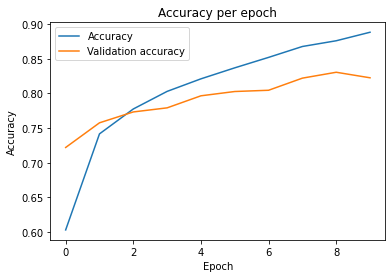

In [ ]:
plot_accuracy(history_train, history_val, 'Accuracy per epoch')


In [ ]:
# This cell is here to assess the quality of the predictions of our model.

'''
Comment:
Using the architecture of vgg16, we trained the model in 10 epoches. 
It has validation accuracy over 0.8, which out performed the cnn built before.
'''